In [1]:
import numpy as np
import os
from tensorflow_privacy.privacy.optimizers.dp_optimizer import *
from tqdm.notebook import tqdm
import pandas as pd
import seaborn as sns
from keras_tqdm import TQDMNotebookCallback
import matplotlib.pyplot as plt

os.environ["CUDA_VISIBLE_DEVICES"] = "2"
import tensorflow as tf

import random; random.seed(42)

%load_ext autoreload
%autoreload 2

tf.compat.v1.enable_eager_execution()
assert tf.executing_eagerly

Using TensorFlow backend.


In [2]:
epochs = 5
batch_size = 75

DP-SGD has three privacy-specific hyperparameters and one existing hyperamater that you must tune:

1. `l2_norm_clip` (float) - The maximum Euclidean (L2) norm of each gradient that is applied to update model parameters. This hyperparameter is used to bound the optimizer's sensitivity to individual training points. 
2. `noise_multiplier` (float) - The amount of noise sampled and added to gradients during training. Generally, more noise results in better privacy (often, but not necessarily, at the expense of lower utility).
3.   `microbatches` (int) - Each batch of data is split in smaller units called microbatches. By default, each microbatch should contain a single training example. This allows us to clip gradients on a per-example basis rather than after they have been averaged across the minibatch. This in turn decreases the (negative) effect of clipping on signal found in the gradient and typically maximizes utility. However, computational overhead can be reduced by increasing the size of microbatches to include more than one training examples. The average gradient across these multiple training examples is then clipped. The total number of examples consumed in a batch, i.e., one step of gradient descent, remains the same. The number of microbatches should evenly divide the batch size. 

In [3]:
l2_norm_clip = 0.5
noise_multiplier = 1
gaussian_noise_var = (l2_norm_clip * noise_multiplier) ** 2
num_microbatches = batch_size

if batch_size % num_microbatches != 0:
  raise ValueError('Batch size should be an integer multiple of the number of microbatches')

In [4]:
train, test = tf.keras.datasets.cifar10.load_data()
train_data, train_labels = train
test_data, test_labels = test

train_data = np.array(train_data, dtype=np.float32) / 255
test_data = np.array(test_data, dtype=np.float32) / 255

train_labels = np.array(train_labels, dtype=np.int32)
test_labels = np.array(test_labels, dtype=np.int32)

train_labels = tf.keras.utils.to_categorical(train_labels, num_classes=10)
test_labels = tf.keras.utils.to_categorical(test_labels, num_classes=10)

assert train_data.min() == 0.
assert train_data.max() == 1.
assert test_data.min() == 0.
assert test_data.max() == 1.

In [5]:
from sklearn.model_selection import train_test_split

# test_size refers to private data size
public_data, private_data, public_labels, private_labels = \
    train_test_split(train_data, train_labels, test_size=99/100)

num_batches = private_data.shape[0] // batch_size

In [6]:
print(public_data.shape)
print(public_labels.shape)
print(private_data.shape)
print(private_labels.shape)

(500, 32, 32, 3)
(500, 10)
(49500, 32, 32, 3)
(49500, 10)


In [7]:
from tensorflow_privacy.privacy.analysis import compute_dp_sgd_privacy

compute_dp_sgd_privacy.compute_dp_sgd_privacy(
    n=private_labels.shape[0], batch_size=batch_size, noise_multiplier=noise_multiplier, epochs=epochs, delta=1e-5)

DP-SGD with sampling rate = 0.152% and noise_multiplier = 1 iterated over 3300 steps satisfies differential privacy with eps = 1.13 and delta = 1e-05.
The optimal RDP order is 12.0.


(1.1305895073622514, 12.0)

In [8]:
# CNN model
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D

def cnn_model():
    model = tf.keras.models.Sequential()
    model.add(Conv2D(32, (3, 3), padding='same',
                     input_shape=train_data.shape[1:]))
    model.add(Activation('relu'))
    model.add(Conv2D(32, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(64, (3, 3), padding='same'))
    model.add(Activation('relu'))
    model.add(Conv2D(64, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(512))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(Dense(train_labels.shape[1]))
    model.add(Activation('softmax'))
    
    model.load_weights('cifar_initial_weights.h5')
    
    return model

In [9]:
loss_fn = tf.keras.losses.CategoricalCrossentropy(
    from_logits=True, reduction=tf.losses.Reduction.NONE)

In [10]:
def get_public_grads_mean_var(public_x, public_y, loss_fn, model):
    # x needs to have extra dimension for number of examples,
    # even if it's 1 for our case
    public_x = np.expand_dims(public_x, axis=1)
    # https://math.stackexchange.com/questions/20593/calculate-variance-from-a-stream-of-sample-values
    mean_k = None
    v_k = None
    k = 0
    for x, y in zip(public_x, public_y):
        k += 1
        with tf.GradientTape() as tape:
            loss_value = loss_fn(y, model(x))
            grad = tape.gradient(loss_value, model.trainable_weights)
        numpy_grad = [t.numpy() for t in grad]
        if k == 1:
            mean_k = numpy_grad
            v_k = [np.zeros(t.shape) for t in numpy_grad]
        else:
            prev_mean_k = mean_k
            mean_k = [mean_k[i] + (t - mean_k[i]) / k for i, t in enumerate(numpy_grad)]
            v_k = [v_k[i] +  np.multiply(t - prev_mean_k[i], 
                                         t - mean_k[i]) 
                   for i, t in enumerate(numpy_grad)]
    unbiased_variance = [t / (k - 1) for t in v_k]
    return mean_k, unbiased_variance

def evaluate_model(model, loss_fn, x, y):
    pred = model(x)
    loss = np.mean(loss_fn(y, pred).numpy())
    acc = np.mean(tf.keras.metrics.categorical_accuracy(y, pred).numpy())
    return (loss, acc)

In [11]:
custom_model = cnn_model()
custom_optimizer = DPAdamGaussianOptimizer(
    l2_norm_clip=l2_norm_clip,
    noise_multiplier=noise_multiplier,
    num_microbatches=num_microbatches)

custom_model.compile(optimizer=custom_optimizer, loss=loss_fn, metrics=['accuracy'])

dpsgd_model = cnn_model()
dpsgd_optimizer = DPAdamGaussianOptimizer(
    l2_norm_clip=l2_norm_clip,
    noise_multiplier=noise_multiplier,
    num_microbatches=num_microbatches)
dpsgd_model.compile(optimizer=dpsgd_optimizer, loss=loss_fn, metrics=['accuracy'])

In [ ]:
# Iterate over epochs.
custom_loss_batches = []
custom_acc_batches = []

dpsgd_loss_batches = []
dpsgd_acc_batches = []

# Used for picking a random minibatch
idx_array = np.arange(private_data.shape[0])

for epoch in tqdm(range(epochs), desc='Epoch'):

    # Iterate over the batches of the dataset.
    for step in tqdm(range(num_batches), desc='Batch'):
        
        # Pick a random minibatch
        random_idx = np.random.choice(idx_array, batch_size)
        x_batch_train = private_data[random_idx]
        y_batch_train = private_labels[random_idx]
        
        ### Normal DPSGD
    
        # Evaluate DPSGD model
        loss, acc = evaluate_model(dpsgd_model, loss_fn, test_data, test_labels)
#         print('DPSGD Loss: %.4f | Acc: %.4f' % (loss, acc))
        dpsgd_loss_batches.append(loss)
        dpsgd_acc_batches.append(acc)
    
        # Open a GradientTape to record the operations run
        # during the forward pass, which enables autodifferentiation.
        with tf.GradientTape(persistent=True) as tape:

            # Run the forward pass of the layer.
            # The operations that the layer applies
            # to its inputs are going to be recorded
            # on the GradientTape.
            logits = dpsgd_model(x_batch_train)  # Logits for this minibatch

            # Compute the loss value for this minibatch.
            loss = lambda: loss_fn(y_batch_train, logits)

            # Use the gradient tape to automatically retrieve
            # the gradients of the trainable variables with respect to the loss.
            grads = dpsgd_optimizer.compute_gradients(loss, dpsgd_model.trainable_weights, gradient_tape=tape)

        del tape

        # Run one step of gradient descent by updating
        # the value of the variables to minimize the loss.
        dpsgd_optimizer.apply_gradients(grads)
        
        ### Our custom DPSGD
    
        # Evaluate custom model
        loss, acc = evaluate_model(custom_model, loss_fn, test_data, test_labels)
#         print('Custom Loss: %.4f | Acc: %.4f' % (loss, acc))
        custom_loss_batches.append(loss)
        custom_acc_batches.append(acc)

        means, variances = get_public_grads_mean_var(public_data, public_labels, loss_fn, custom_model)
        
        # Open a GradientTape to record the operations run
        # during the forward pass, which enables autodifferentiation.
        with tf.GradientTape(persistent=True) as tape:

            # Run the forward pass of the layer.
            # The operations that the layer applies
            # to its inputs are going to be recorded
            # on the GradientTape.
            logits = custom_model(x_batch_train)  # Logits for this minibatch

            # Compute the loss value for this minibatch.
            loss = lambda: loss_fn(y_batch_train, logits)

            # Use the gradient tape to automatically retrieve
            # the gradients of the trainable variables with respect to the loss.
            grads = custom_optimizer.compute_gradients(loss, custom_model.trainable_weights,
                                                              gradient_tape=tape)

        del tape
        
        # X = N(means, variances)
        # Y = X + N(0, gaussian_noise_var)
        # MLE of X is ((variances * Y) + (gaussian_noise_var * means)) / (variances + gaussian_noise_var)
        # https://www.wolframalpha.com/input/?i=differentiate+-log%28%CF%83%29+-+1%2F2+log%282+%CF%80%29+-+1%2F2+%28%28x+-+%CE%BC%29%2F%CF%83%29%5E2+-log%28%CE%A3%29+-+1%2F2+log%282+%CF%80%29+-+1%2F2+%28%28y+-+x%29%2F%CE%A3%29%5E2+wrt+x
        # https://www.wolframalpha.com/input/?i=solve+%28y+-+x%29%2F%CE%A3%5E2+-+%28x+-+%CE%BC%29%2F%CF%83%5E2+for+x
        Ys = [grad[0] for grad in grads]
        Xs = [((Y * variances[i]) + (means[i] * gaussian_noise_var)) / (variances[i] + gaussian_noise_var)
              for i, Y in enumerate(Ys)]
        adjusted_grads = list(zip(Xs, custom_model.trainable_weights))

        # Run one step of gradient descent by updating
        # the value of the variables to minimize the loss.
        custom_optimizer.apply_gradients(adjusted_grads)

Instructions for updating:
Use tf.identity instead.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [ ]:
evaluate_model(custom_model, loss_fn, test_data, test_labels)

In [ ]:
evaluate_model(dpsgd_model, loss_fn, test_data, test_labels)

In [ ]:
baseline_model = cnn_model()
baseline_model.compile(optimizer='adam',
                       loss=loss_fn, metrics=['accuracy'])

In [ ]:
baseline_history = baseline_model.fit(public_data, public_labels,
                    epochs=epochs,
                    batch_size=batch_size,
                    validation_data=(test_data, test_labels),
                    callbacks=[TQDMNotebookCallback()])

In [ ]:
evaluate_model(baseline_model, loss_fn, test_data, test_labels)

In [ ]:
baseline_loss_per_batch = [l for e in baseline_history.history['val_loss'] for l in e ]
baseline_loss_per_epoch = [np.mean(e) for e in baseline_history.history['val_loss']]
baseline_acc_per_epoch = baseline_history.history['val_acc']

In [18]:
metrics = pd.DataFrame({'custom_loss': custom_loss_batches,
                        'dpsgd_loss': dpsgd_loss_batches,
                        'custom_acc': custom_acc_batches,
                        'dpsgd_acc': dpsgd_acc_batches,
#                         'grad_norm': public_norms,
#                         'baseline_loss': baseline_loss_per_epoch,
#                         'baseline_acc': baseline_acc_per_epoch
                       })
print(metrics)

      custom_acc  custom_loss  dpsgd_acc  dpsgd_loss
0         0.0994     2.302757     0.0994    2.302757
1         0.1193     2.300958     0.0992    2.302734
2         0.1575     2.298151     0.1006    2.302719
3         0.1219     2.293129     0.1011    2.302710
4         0.1593     2.283220     0.1015    2.302695
5         0.1562     2.277267     0.1016    2.302681
6         0.1091     2.324022     0.1041    2.302671
7         0.1556     2.282122     0.1045    2.302656
8         0.1850     2.263874     0.1052    2.302639
9         0.1682     2.265878     0.1063    2.302623
10        0.1768     2.257418     0.1066    2.302606
11        0.2048     2.245733     0.1080    2.302588
12        0.2015     2.245978     0.1076    2.302570
13        0.1978     2.243800     0.1079    2.302553
14        0.2077     2.239355     0.1072    2.302539
15        0.2247     2.232014     0.1087    2.302523
16        0.2325     2.221964     0.1078    2.302508
17        0.2363     2.219252     0.1076    2.

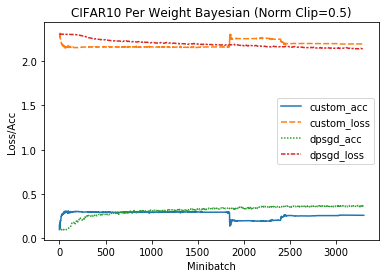

In [19]:
ax = sns.lineplot(data=metrics)
ax.set(xlabel='Minibatch', ylabel='Loss/Acc', 
       title='CIFAR10 Per Weight Bayesian (Norm Clip={})'.format(l2_norm_clip))
plt.savefig('cifar_per-weight-bayesian_dpsgd-norm{}.png'.format(l2_norm_clip))